In [1]:
# =============================================================================
# BLOCK 1: DATA PIPELINE, MODEL ARCHITECTURE, AND TRAINING LOOP
# =============================================================================
import os
import zipfile
import json
import random
import numpy as np
import time
from PIL import Image, ImageOps

import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models, transforms

# --- Configuration & Hyperparameters ---
CONFIG = {
    "ZIP_PATH": "archive2.zip",
    "EXTRACT_PATH": "./dataset",
    "IMG_SIZE": 256,
    "BATCH_SIZE": 32,
    "LEARNING_RATE": 1e-3,
    "WEIGHT_DECAY": 1e-4,
    "NUM_EPOCHS": 35,
    "SCHEDULER_PATIENCE": 3,
    "SCHEDULER_FACTOR": 0.1,
    "DEVICE": torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

print(f"--- System Configuration ---")
print(f"Device: {CONFIG['DEVICE']}")
print(f"Batch Size: {CONFIG['BATCH_SIZE']}")
print(f"Epochs: {CONFIG['NUM_EPOCHS']}")

# --- 1. Data Preparation ---
if os.path.exists(CONFIG["ZIP_PATH"]):
    with zipfile.ZipFile(CONFIG["ZIP_PATH"], 'r') as zip_ref:
        zip_ref.extractall(CONFIG["EXTRACT_PATH"])
    print("Dataset extracted successfully.")

# Locate resources
REAL_IMG_DIR = None
max_jpg = 0
for root, dirs, files in os.walk(CONFIG["EXTRACT_PATH"]):
    count = len([f for f in files if f.lower().endswith(('.jpg', '.png'))])
    if count > max_jpg:
        max_jpg = count
        REAL_IMG_DIR = root

METADATA_PATH = None
for root, dirs, files in os.walk(CONFIG["EXTRACT_PATH"]):
    if "metadata.json" in files:
        METADATA_PATH = os.path.join(root, "metadata.json")
        break

if not REAL_IMG_DIR or not METADATA_PATH:
    raise FileNotFoundError("Could not locate images or metadata.json.")

# --- 2. Custom Dataset Class (with Augmentation) ---
class AnimalLocalizationDataset(Dataset):
    def __init__(self, json_file, img_dir, transform=None, img_size=224, augment=False):
        with open(json_file, 'r') as f:
            self.data_dict = json.load(f)

        self.valid_keys = []
        available_files = set(os.listdir(img_dir))
        for key in self.data_dict.keys():
            if key in available_files:
                self.valid_keys.append(key)

        self.img_dir = img_dir
        self.transform = transform
        self.img_size = img_size
        self.augment = augment

    def __len__(self):
        return len(self.valid_keys)

    def __getitem__(self, idx):
        img_name = self.valid_keys[idx]
        data = self.data_dict[img_name]
        img_path = os.path.join(self.img_dir, img_name)

        image = Image.open(img_path).convert("RGB")
        w_old, h_old = image.size

        box_list = data['bbox'] # [xmin, ymin, xmax, ymax]
        xmin, ymin, xmax, ymax = box_list

        # Augmentation: Random Horizontal Flip (50% probability)
        # We must adjust the bounding box coordinates if the image is flipped
        if self.augment and random.random() > 0.5:
            image = ImageOps.mirror(image)
            new_xmin = w_old - xmax
            new_xmax = w_old - xmin
            xmin, xmax = new_xmin, new_xmax

        # Resize Image & Box
        image = image.resize((self.img_size, self.img_size))

        box = torch.tensor([xmin, ymin, xmax, ymax], dtype=torch.float32)
        box[0] = box[0] * (self.img_size / w_old)
        box[1] = box[1] * (self.img_size / h_old)
        box[2] = box[2] * (self.img_size / w_old)
        box[3] = box[3] * (self.img_size / h_old)

        if self.transform:
            image = self.transform(image)

        return image, box

# --- 3. Splitting & Loaders ---
# Define Transforms
train_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create Splits manually to ensure correct augmentation flags
full_keys = list(json.load(open(METADATA_PATH)).keys())
valid_keys = [k for k in full_keys if k in os.listdir(REAL_IMG_DIR)]
random.shuffle(valid_keys)

n_total = len(valid_keys)
n_train = int(0.7 * n_total)
n_val = int(0.15 * n_total)

train_keys = valid_keys[:n_train]
val_keys = valid_keys[n_train:n_train+n_val]
test_keys = valid_keys[n_train+n_val:]

def create_loader(keys, transform, augment, shuffle):
    ds = AnimalLocalizationDataset(METADATA_PATH, REAL_IMG_DIR, transform=transform, img_size=CONFIG["IMG_SIZE"], augment=augment)
    ds.valid_keys = keys
    return DataLoader(ds, batch_size=CONFIG["BATCH_SIZE"], shuffle=shuffle), ds

train_loader, train_dataset = create_loader(train_keys, train_transform, augment=True, shuffle=True)
val_loader, val_dataset = create_loader(val_keys, val_test_transform, augment=False, shuffle=False)
test_loader, test_dataset = create_loader(test_keys, val_test_transform, augment=False, shuffle=False)

print(f"Data Split: Train={len(train_dataset)}, Val={len(val_dataset)}, Test={len(test_dataset)}")

# --- 4. Model Definition (ResNet18 + SmoothL1) ---
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_features, 4)
)
model = model.to(CONFIG["DEVICE"])

criterion = nn.SmoothL1Loss()
optimizer = optim.AdamW(model.parameters(), lr=CONFIG["LEARNING_RATE"], weight_decay=CONFIG["WEIGHT_DECAY"])
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=CONFIG["SCHEDULER_FACTOR"], patience=CONFIG["SCHEDULER_PATIENCE"])

# --- 5. Training Loop ---
def calculate_iou(pred_box, true_box):
    x1 = torch.max(pred_box[:, 0], true_box[:, 0])
    y1 = torch.max(pred_box[:, 1], true_box[:, 1])
    x2 = torch.min(pred_box[:, 2], true_box[:, 2])
    y2 = torch.min(pred_box[:, 3], true_box[:, 3])
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    box1_area = (pred_box[:, 2] - pred_box[:, 0]) * (pred_box[:, 3] - pred_box[:, 1])
    box2_area = (true_box[:, 2] - true_box[:, 0]) * (true_box[:, 3] - true_box[:, 1])
    union = box1_area + box2_area - intersection
    return (intersection / (union + 1e-6)).mean()

history = {'train_loss': [], 'val_loss': [], 'train_iou': [], 'val_iou': []}

print("\n--- Starting Training Process ---")
start_time = time.time()

for epoch in range(CONFIG["NUM_EPOCHS"]):
    # Training Phase
    model.train()
    running_loss, running_iou = 0.0, 0.0

    for images, boxes in train_loader:
        images, boxes = images.to(CONFIG["DEVICE"]), boxes.to(CONFIG["DEVICE"])
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, boxes)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_iou += calculate_iou(outputs.detach(), boxes).item()

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_iou = running_iou / len(train_loader)

    # Validation Phase
    model.eval()
    val_loss_sum, val_iou_sum = 0.0, 0.0

    with torch.no_grad():
        for images, boxes in val_loader:
            images, boxes = images.to(CONFIG["DEVICE"]), boxes.to(CONFIG["DEVICE"])
            outputs = model(images)
            loss_val = criterion(outputs, boxes)
            val_loss_sum += loss_val.item()
            val_iou_sum += calculate_iou(outputs, boxes).item()

    epoch_val_loss = val_loss_sum / len(val_loader)
    epoch_val_iou = val_iou_sum / len(val_loader)

    # Update History
    history['train_loss'].append(epoch_train_loss)
    history['val_loss'].append(epoch_val_loss)
    history['train_iou'].append(epoch_train_iou)
    history['val_iou'].append(epoch_val_iou)

    # Scheduler Step
    scheduler.step(epoch_val_loss)
    current_lr = optimizer.param_groups[0]['lr']

    print(f"Epoch {epoch+1}/{CONFIG['NUM_EPOCHS']} | LR: {current_lr:.1e} | "
          f"Train IoU: {epoch_train_iou*100:.1f}% | Val IoU: {epoch_val_iou*100:.1f}%")

print(f"\nTraining completed in {(time.time() - start_time)/60:.1f} minutes.")

--- System Configuration ---
Device: cuda
Batch Size: 32
Epochs: 35
Dataset extracted successfully.
Data Split: Train=2225, Val=476, Test=478
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 44.7M/44.7M [00:00<00:00, 161MB/s]



--- Starting Training Process ---
Epoch 1/35 | LR: 1.0e-03 | Train IoU: 0.0% | Val IoU: 0.1%
Epoch 2/35 | LR: 1.0e-03 | Train IoU: 3.9% | Val IoU: 13.4%
Epoch 3/35 | LR: 1.0e-03 | Train IoU: 28.2% | Val IoU: 47.9%
Epoch 4/35 | LR: 1.0e-03 | Train IoU: 48.3% | Val IoU: 53.4%
Epoch 5/35 | LR: 1.0e-03 | Train IoU: 49.9% | Val IoU: 54.2%
Epoch 6/35 | LR: 1.0e-03 | Train IoU: 50.8% | Val IoU: 52.6%
Epoch 7/35 | LR: 1.0e-03 | Train IoU: 51.9% | Val IoU: 54.2%
Epoch 8/35 | LR: 1.0e-03 | Train IoU: 53.2% | Val IoU: 56.8%
Epoch 9/35 | LR: 1.0e-03 | Train IoU: 53.6% | Val IoU: 56.8%
Epoch 10/35 | LR: 1.0e-03 | Train IoU: 54.3% | Val IoU: 57.8%
Epoch 11/35 | LR: 1.0e-03 | Train IoU: 55.4% | Val IoU: 57.6%
Epoch 12/35 | LR: 1.0e-03 | Train IoU: 55.7% | Val IoU: 57.2%
Epoch 13/35 | LR: 1.0e-03 | Train IoU: 56.5% | Val IoU: 58.9%
Epoch 14/35 | LR: 1.0e-03 | Train IoU: 57.8% | Val IoU: 59.7%
Epoch 15/35 | LR: 1.0e-03 | Train IoU: 57.6% | Val IoU: 59.9%
Epoch 16/35 | LR: 1.0e-03 | Train IoU: 58.8% | 

Evaluating model on the Test Set...
Evaluation complete.


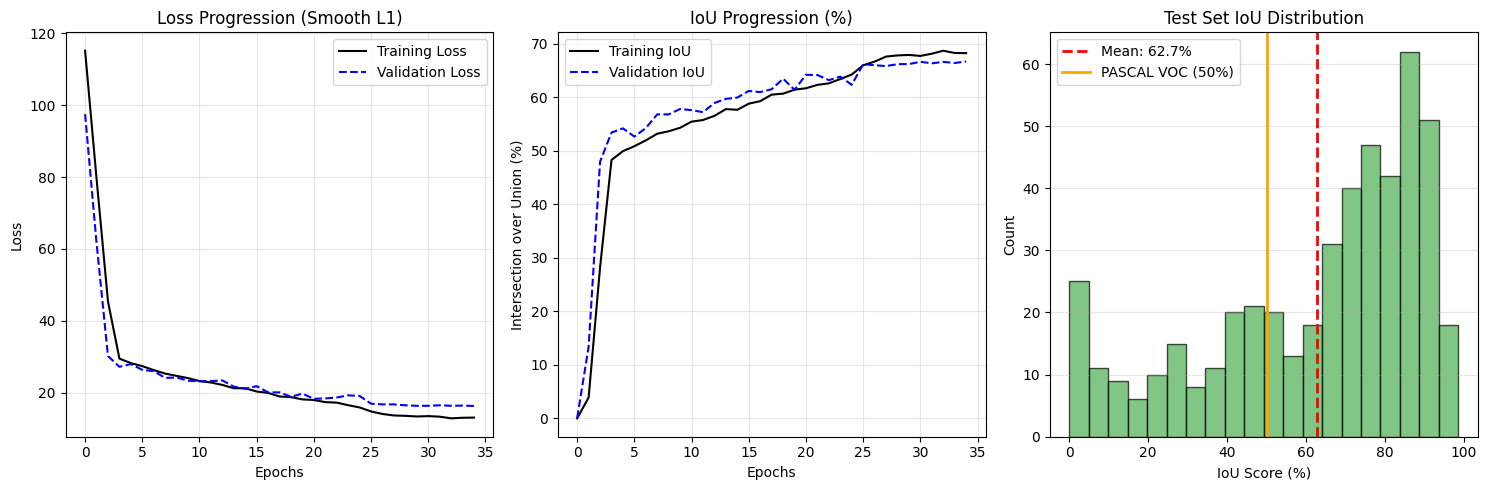

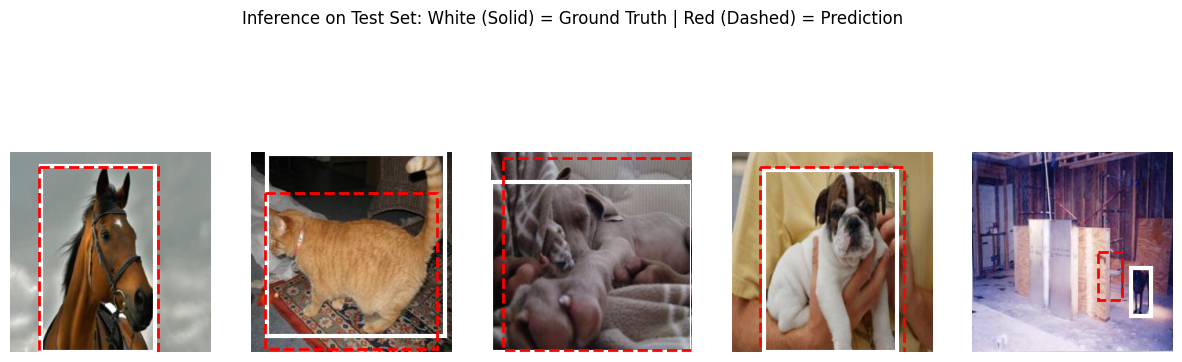


            SUMMARY OF EXPERIMENTS (KEY FACTS)

1. DATASET SPLIT
   - Total Images: 3179
   - Training Set:   2225 images (70%)
   - Validation Set: 476 images (15%)
   - Test Set:       478 images (15%)

2. HYPERPARAMETERS
   - Model:          ResNet18 (Pretrained)
   - Optimizer:      AdamW
   - Learning Rate:  0.001
   - Weight Decay:   0.0001
   - Batch Size:     32
   - Epochs:         35
   - Scheduler:      ReduceLROnPlateau (Factor: 0.1, Patience: 3)
   - Loss Function:  SmoothL1Loss

3. FINAL PERFORMANCE (TEST SET)
   - Mean IoU:       62.72%
   - Accuracy (>0.5):71.13%


In [2]:
# =============================================================================
# BLOCK 2: EVALUATION, VISUALIZATION AND KEY METRICS
# =============================================================================
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# --- 1. Evaluate on Test Set (The "Unseen" Data) ---
print("Evaluating model on the Test Set...")
model.eval()
test_ious = []

with torch.no_grad():
    for images, boxes in test_loader:
        images, boxes = images.to(CONFIG["DEVICE"]), boxes.to(CONFIG["DEVICE"])
        outputs = model(images)

        # Calculate individual IoUs for histogram
        for i in range(len(outputs)):
            iou = calculate_iou(outputs[i].unsqueeze(0), boxes[i].unsqueeze(0)).item()
            test_ious.append(iou)

test_ious = np.array(test_ious)
final_test_iou_mean = np.mean(test_ious) * 100
accuracy_threshold = 0.5
test_accuracy = np.sum(test_ious > accuracy_threshold) / len(test_ious) * 100

print(f"Evaluation complete.")

# --- 2. Visualization (Professional Style) ---
plt.figure(figsize=(15, 5))

# Plot A: Loss Curves
plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Training Loss', color='black', linestyle='-')
plt.plot(history['val_loss'], label='Validation Loss', color='blue', linestyle='--')
plt.title('Loss Progression (Smooth L1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot B: IoU Curves
plt.subplot(1, 3, 2)
plt.plot([x * 100 for x in history['train_iou']], label='Training IoU', color='black', linestyle='-')
plt.plot([x * 100 for x in history['val_iou']], label='Validation IoU', color='blue', linestyle='--')
plt.title('IoU Progression (%)')
plt.xlabel('Epochs')
plt.ylabel('Intersection over Union (%)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot C: Test Set Histogram (MET PASCAL VOC LIJN)
plt.subplot(1, 3, 3)
plt.hist(test_ious * 100, bins=20, color='#4CAF50', edgecolor='black', alpha=0.7)

# 1. Gemiddelde lijn (Rood - Gestreept)
plt.axvline(final_test_iou_mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {final_test_iou_mean:.1f}%')

# 2. PASCAL VOC Threshold lijn (Oranje - Solid)
plt.axvline(50, color='orange', linestyle='-', linewidth=2, label='PASCAL VOC (50%)')

plt.title('Test Set IoU Distribution')
plt.xlabel('IoU Score (%)')
plt.ylabel('Count')
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# --- 3. Inference Samples ---
def show_inference_samples(model, dataset, num_samples=5):
    model.eval()
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    plt.figure(figsize=(15, 5))

    for i, idx in enumerate(indices):
        image, true_box = dataset[idx]
        with torch.no_grad():
            input_tensor = image.unsqueeze(0).to(CONFIG["DEVICE"])
            pred_box = model(input_tensor).cpu().squeeze(0)

        # Undo normalization for display
        inv_normalize = transforms.Normalize(
            mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
            std=[1/0.229, 1/0.224, 1/0.225])
        display_img = inv_normalize(image).permute(1, 2, 0).numpy()
        display_img = np.clip(display_img, 0, 1)

        ax = plt.subplot(1, num_samples, i + 1)
        ax.imshow(display_img)

        # Ground Truth (Solid White)
        rect_true = patches.Rectangle((true_box[0], true_box[1]),
                                      true_box[2]-true_box[0], true_box[3]-true_box[1],
                                      linewidth=3, edgecolor='white', facecolor='none', label='Ground Truth')
        # Prediction (Dashed Red)
        rect_pred = patches.Rectangle((pred_box[0], pred_box[1]),
                                      pred_box[2]-pred_box[0], pred_box[3]-pred_box[1],
                                      linewidth=2, edgecolor='red', facecolor='none', linestyle='--', label='Prediction')
        ax.add_patch(rect_true)
        ax.add_patch(rect_pred)
        ax.axis('off')

    plt.suptitle("Inference on Test Set: White (Solid) = Ground Truth | Red (Dashed) = Prediction")
    plt.show()

show_inference_samples(model, test_dataset)

# --- 4. Summary of Experiments (Facts Only) ---
print("\n" + "="*60)
print("            SUMMARY OF EXPERIMENTS (KEY FACTS)")
print("="*60)

print(f"\n1. DATASET SPLIT")
print(f"   - Total Images: {len(full_keys)}")
print(f"   - Training Set:   {len(train_dataset)} images (70%)")
print(f"   - Validation Set: {len(val_dataset)} images (15%)")
print(f"   - Test Set:       {len(test_dataset)} images (15%)")

print(f"\n2. HYPERPARAMETERS")
print(f"   - Model:          ResNet18 (Pretrained)")
print(f"   - Optimizer:      AdamW")
print(f"   - Learning Rate:  {CONFIG['LEARNING_RATE']}")
print(f"   - Weight Decay:   {CONFIG['WEIGHT_DECAY']}")
print(f"   - Batch Size:     {CONFIG['BATCH_SIZE']}")
print(f"   - Epochs:         {CONFIG['NUM_EPOCHS']}")
print(f"   - Scheduler:      ReduceLROnPlateau (Factor: {CONFIG['SCHEDULER_FACTOR']}, Patience: {CONFIG['SCHEDULER_PATIENCE']})")
print(f"   - Loss Function:  SmoothL1Loss")

print(f"\n3. FINAL PERFORMANCE (TEST SET)")
print(f"   - Mean IoU:       {final_test_iou_mean:.2f}%")
print(f"   - Accuracy (>0.5):{test_accuracy:.2f}%")
print("="*60)